<a href="https://colab.research.google.com/github/GuiSSMartins/DTx-Project/blob/main/DTx_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from graphviz import Digraph # para representação gráfica de grafos direcionados (utiliza linguagem dot)
import matplotlib.image as mpimg # operações relacionadas a imagens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc #importing garbage collector
import time

In [ ]:
# função para reduzir a dimensão de um dataset
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### A análise exploratória dos dados e as suas coneções passam a ser feitas no KNIME!!!!!!

## Decomposição da Série Temporal

In [ ]:
df_loja1_serie_temporal_agregada = pd.read_csv('loja1.csv')

import numpy as np
import tensorflow as tf

df_loja1_serie_temporal_agregada = reduce_mem_usage(df_loja1_serie_temporal_agregada)

n_periods = 1913

# eliminar as colunas indesejadas para a construção da série temporal
df_time_series = pd.DataFrame(data={"Vendas": df_loja1_serie_temporal_agregada['Vendas_do_dia'].tolist()}, index=df_loja1_serie_temporal_agregada['date'])

Mem. usage decreased to  0.05 Mb (63.8% reduction)


In [ ]:
df_loja1_serie_temporal_agregada

,date,wm_yr_wk,wday,month,year,d,evento,Vendas_do_dia,week_group
0,2011-01-29,11101,1,1,2011,d_1,0,4337,0
1,2011-01-30,11101,2,1,2011,d_2,0,4155,0
2,2011-01-31,11101,3,1,2011,d_3,0,2816,1
3,2011-02-01,11101,4,2,2011,d_4,0,3051,1
4,2011-02-02,11101,5,2,2011,d_5,0,2630,1
...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,5,4,2016,d_1909,0,3722,1
1909,2016-04-21,11612,6,4,2016,d_1910,0,3709,1
1910,2016-04-22,11612,7,4,2016,d_1911,0,4387,1
1911,2016-04-23,11613,1,4,2016,d_1912,0,5577,0


In [ ]:
print(df_loja1_serie_temporal_agregada.columns)

Index(['date', 'wm_yr_wk', 'wday', 'month', 'year', 'd', 'evento',
       'Vendas_do_dia', 'week_group'],
      dtype='object')


In [ ]:
print(df_time_series)

            Vendas
date              
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
...            ...
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113

[1913 rows x 1 columns]


## Carregar dados (agora concatenados)

In [ ]:
df_loja1_RNN = reduce_mem_usage(df_loja1_serie_temporal_agregada)

Mem. usage decreased to  0.05 Mb (0.0% reduction)


# Treino de Modelos

##### Rede Neuronal Recurrente (RNN)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

import numpy as np

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8, 6]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 7]  # Access single column directly

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

print(selected_output_column.values)

# Fit scaler to the data and transform it
selected_input_columns = scaler.fit_transform(selected_input_columns)
selected_output_column = scaler.fit_transform(selected_output_column.values.reshape(-1, 1))

import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

# Assuming selected_input_columns and selected_output_column are arrays or lists
input_data = selected_input_columns[:-7]
targets = selected_output_column[7:]

# Assuming both input_data and targets are arrays or lists
sequence_length = 7
sequences = [(input_data[i:i+sequence_length], targets[i+sequence_length]) for i in range(len(input_data) - sequence_length)]

# Extract input sequences and targets
input_sequences = [seq[0] for seq in sequences]
target_values = [seq[1] for seq in sequences]

# Convert lists to TensorFlow tensors
input_sequences_tensor = tf.constant(input_sequences, dtype=tf.float32)
target_values_tensor = tf.constant(target_values, dtype=tf.float32)

# Create a TensorFlow dataset from tensors
dataset = tf.data.Dataset.from_tensor_slices((input_sequences_tensor, target_values_tensor))

# Shuffle and batch your dataset
batch_size = 32
buffer_size = len(sequences)
dataset = dataset.shuffle(buffer_size).batch(batch_size)

for batch in dataset:
    inputs, target = batch
    # Now you can use inputs and target for training
    break

[4337 4155 2816 ... 4387 5577 6113]


In [ ]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 7, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
inputs, targets = batch

inputs

<tf.Tensor: shape=(32, 7, 5), dtype=float32, numpy=
array([[[-1.5573906e+00, -9.9836791e-01, -4.9012724e-01, -1.5782509e+00,
         -2.9588807e-01],
        [-1.5573906e+00, -4.9853072e-01, -1.8199420e+00,  6.3361281e-01,
         -2.9588807e-01],
        [-1.5573906e+00,  1.3064223e-03, -1.5104690e+00,  6.3361281e-01,
         -2.9588807e-01],
        ...,
        [-1.5573906e+00,  1.0009807e+00, -1.4910631e+00,  6.3361281e-01,
         -2.9588807e-01],
        [-1.5573906e+00,  1.5008179e+00, -1.0723042e+00,  6.3361281e-01,
         -2.9588807e-01],
        [-1.5507405e+00, -1.4982051e+00,  6.9579758e-02, -1.5782509e+00,
         -2.9588807e-01]],

       [[-1.2647871e+00, -1.4982051e+00,  2.1257059e-01, -1.5782509e+00,
         -2.9588807e-01],
        [-1.2647871e+00, -9.9836791e-01, -1.4093540e+00, -1.5782509e+00,
          3.3796566e+00],
        [-1.2647871e+00, -4.9853072e-01, -9.8945148e-02,  6.3361281e-01,
         -2.9588807e-01],
        ...,
        [-1.2647871e+00,  5.0

In [ ]:
targets

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 0.06753703],
       [ 0.2483183 ],
       [ 0.35760415],
       [-0.36552092],
       [-0.96914655],
       [ 1.7027394 ],
       [-0.15818422],
       [ 0.36271098],
       [ 2.086772  ],
       [ 0.3841596 ],
       [-1.2009959 ],
       [-0.15103467],
       [ 1.642479  ],
       [-1.1397141 ],
       [ 0.00931934],
       [-0.70563483],
       [-0.6402676 ],
       [-0.6229044 ],
       [-0.76691663],
       [ 0.7069104 ],
       [ 1.1603956 ],
       [ 2.567834  ],
       [ 1.7538075 ],
       [ 0.46791136],
       [-1.9118646 ],
       [ 2.29513   ],
       [ 0.15741698],
       [ 0.5863895 ],
       [-1.673887  ],
       [ 1.5056163 ],
       [-0.1888251 ],
       [-0.06728289]], dtype=float32)>

In [ ]:
import tensorflow as tf

# Assuming 'dataset' is your BatchObject and 'train_split_ratio' is the ratio of data you want in the training set
def split_BatchDataset(dataset, train_split_ratio=0.8):
    # Get the total number of elements in the dataset
    total_elements = sum(1 for _ in dataset)

    # Calculate the number of elements for the training set
    train_elements = int(total_elements * train_split_ratio)

    # Create a dataset with train_elements elements for the training set
    train_dataset = dataset.take(train_elements)

    # Create a dataset with the remaining elements for the validation set
    test_dataset = dataset.skip(train_elements)

    return train_dataset, test_dataset

# Example usage
train_dataset, test_dataset = split_BatchDataset(dataset)

In [ ]:
# Define the RNN model

#'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout

# Define the RNN model

model = Sequential([
    LSTM(50, input_shape=(7, 5), return_sequences=True),  # LSTM layer with return_sequences=True to return sequences
    Dropout(0.2),  # Dropout layer to prevent overfitting
    LSTM(50, return_sequences=False),  # Another LSTM layer without returning sequences
    Dropout(0.2),  # Dropout layer
    Dense(10, activation='relu'),  # Dense layer with ReLU activation
    Dense(1)  # Output layer
])
#'''

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

import numpy as np

# Inicializar listas para armazenar os dados
data_list = []
label_list = []

# Iterar sobre o conjunto de dados e extrair os dados e rótulos
for batch in train_dataset:
    data, label = batch  # Extrair os dados e rótulos da tupla
    data_list.append(data.numpy())  # Converter os dados para um array NumPy
    label_list.append(label.numpy())  # Converter os rótulos para um array NumPy

# Converter as listas de dados e rótulos para arrays NumPy
train_data_numpy = np.concatenate(data_list, axis=0)
train_labels_numpy = np.concatenate(label_list, axis=0)

# Agora você pode usar train_data_numpy e train_labels_numpy no método fit()
model.fit(train_data_numpy, train_labels_numpy, epochs=150, validation_split=0.2)

Epoch 1/150
39/39 [==============================] - 6s 26ms/step - loss: 0.6863 - val_loss: 0.4950
Epoch 2/150
39/39 [==============================] - 0s 8ms/step - loss: 0.4508 - val_loss: 0.3565
Epoch 3/150
39/39 [==============================] - 0s 8ms/step - loss: 0.4071 - val_loss: 0.3698
Epoch 4/150
39/39 [==============================] - 0s 7ms/step - loss: 0.3898 - val_loss: 0.3398
Epoch 5/150
39/39 [==============================] - 0s 7ms/step - loss: 0.3741 - val_loss: 0.3435
Epoch 6/150
39/39 [==============================] - 0s 8ms/step - loss: 0.3741 - val_loss: 0.3414
Epoch 7/150
39/39 [==============================] - 0s 7ms/step - loss: 0.3780 - val_loss: 0.3518
Epoch 8/150
39/39 [==============================] - 0s 8ms/step - loss: 0.3733 - val_loss: 0.3360
Epoch 9/150
39/39 [==============================] - 0s 8ms/step - loss: 0.3707 - val_loss: 0.3440
Epoch 10/150
39/39 [==============================] - 0s 7ms/step - loss: 0.3717 - val_loss: 0.3392
Epoch 11

In [ ]:
# Make predictions
predictions = model.predict(test_dataset)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

print("Predictions:")
print(len(predictions))

12/12 [==============================] - 1s 3ms/step
Predictions:
363


[2134.2896 2319.4707 2430.136  2445.3972 2480.9045 2481.3665 2487.3777
 2527.1558 2535.544  2543.9382 2547.4119 2554.7136 2558.0588 2573.7578
 2583.4587 2597.5007 2641.8044 2681.6475 2687.9277 2702.2476 2726.47
 2728.0425 2744.0747 2746.3818 2782.5544 2791.435  2795.5579 2824.775
 2828.7815 2834.9475 2861.4038 2872.9385 2905.1826 2928.0247 2928.8386
 2937.6929 2940.6675 2941.5962 2981.58   2988.6716 2995.2349 2995.7822
 2999.5034 3008.2568 3011.661  3043.4243 3050.1885 3074.1702 3076.4045
 3077.9458 3088.5208 3090.0757 3095.048  3114.6038 3119.7415 3132.7239
 3149.0298 3165.6958 3166.3706 3182.5715 3183.718  3194.8767 3197.232
 3202.7976 3208.545  3215.8438 3216.2039 3220.9648 3222.3665 3228.6099
 3231.3904 3242.7544 3243.6042 3252.922  3253.333  3257.3977 3269.199
 3282.6865 3283.9092 3291.1714 3291.562  3293.0217 3308.2249 3309.6643
 3309.955  3312.8113 3324.8594 3340.8093 3351.4531 3364.374  3367.0112
 3378.9243 3384.061  3408.6707 3410.6057 3410.9976 3420.0205 3434.7961
 3441.381  

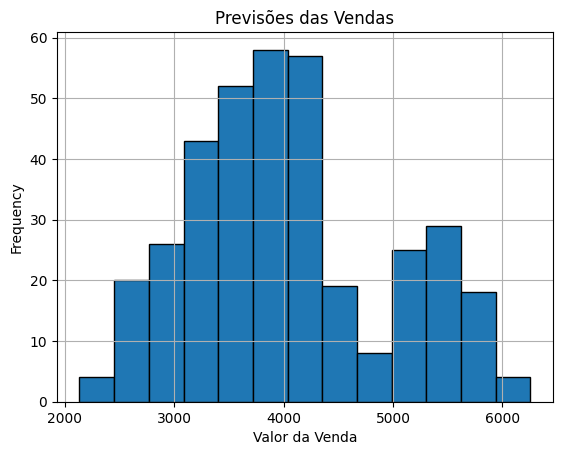

In [ ]:
# Flatten the array of arrays into a single list
flat_data = [item for sublist in predictions for item in sublist]

# Count the frequency of each item
unique_items, frequencies = np.unique(flat_data, return_counts=True)

print(unique_items)
print(frequencies)

# Assuming you have a list of data points called 'data'
plt.hist(predictions, bins='auto', edgecolor='black')  # 'auto' for automatic bin size determination
plt.xlabel('Valor da Venda')
plt.ylabel('Frequency')
plt.title('Previsões das Vendas')
plt.grid(True)  # Add grid lines
plt.show()

In [ ]:
# Assuming test_dataset is an instance of _SkipDataset
targets_test = []

# Iterate over the dataset to extract targets
for batch in test_dataset:
    inputs, target = batch  # Adjust this line according to the actual attribute/method name
    for value in target:
      targets_test.append(value)

targets_test = scaler.inverse_transform(targets_test)

print("Targets:", len(targets_test))

Targets: 363


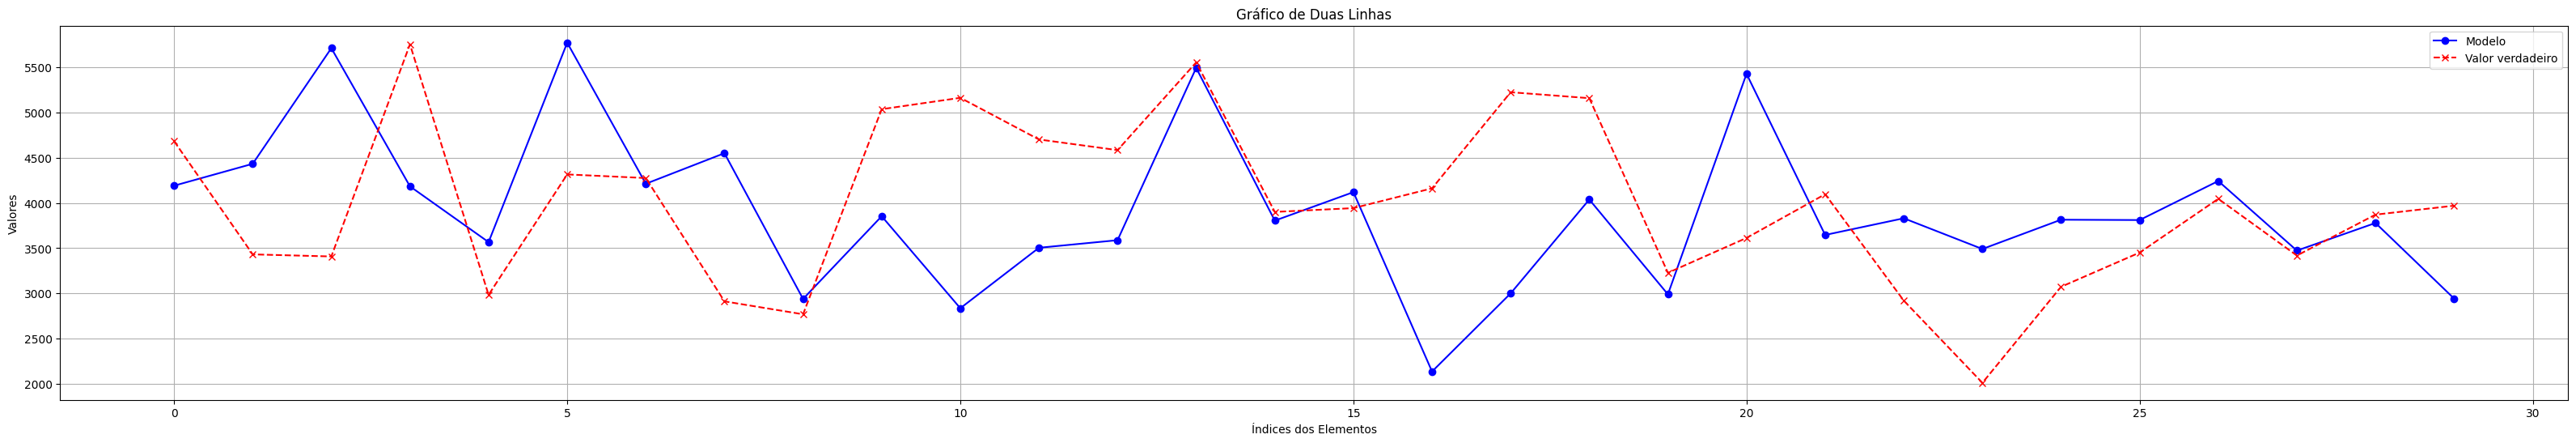

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 6))

# Criar o gráfico de linhas
plt.plot(predictions[:30], label='Modelo', color='blue', linestyle='-', marker='o')
plt.plot(targets_test[:30], label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(targets_test, predictions)

# MSE calculation
mse = mean_squared_error(targets_test, predictions)

# RMSE calculation (square root of MSE)
rmse = np.sqrt(mse)

In [ ]:
mae

1112.596191851371

In [ ]:
mse

1902210.9947471938

In [ ]:
rmse

1379.2066541121362

In [ ]:
sum(targets_test - predictions)/len(predictions)

array([79.82890719])

### Monte-Carlo dropout

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense, Lambda
import keras.backend as K
import numpy as np

# Função para amostrar usando Monte Carlo Dropout
def mc_dropout(x):
    # Aplicar dropout
    output_with_dropout = K.dropout(x, level=dropout_rate)
    return output_with_dropout

# Definindo parâmetros de Monte Carlo Dropout
num_samples = 10  # Número de amostras de dropout
dropout_rate = 0.2  # Taxa de dropout

# Input
inputs = Input(shape=(7, 5))

# LSTM com Monte Carlo Dropout
lstm_output = LSTM(50, return_sequences=True)(inputs)
lstm_output_dropout = Lambda(mc_dropout)(lstm_output)
dropout_layer = Dropout(0.1)(lstm_output_dropout)

# LSTM com Monte Carlo Dropout
lstm_output2 = LSTM(50, return_sequences=False)(dropout_layer)
lstm_output2_dropout = Lambda(mc_dropout)(lstm_output2)
dropout_layer2 = Dropout(0.1)(lstm_output2_dropout)

# Camadas densas
dense_output = Dense(50, activation='relu')(dropout_layer2)
dense_output_dropout = Lambda(mc_dropout)(dense_output)
dropout_layer3 = Dropout(0.1)(dense_output_dropout)

# Camada de saída
mean_output = Dense(1)(dropout_layer3)
variance_output = Dense(1)(dropout_layer3)  # Separate output for variance

# Modelo final
model = Model(inputs=inputs, outputs=[mean_output, variance_output])

In [ ]:
import tensorflow as tf

# Custom loss function that includes both mean squared error and variance
def custom_loss(y_true, y_pred):
    mean_predictions = y_pred[:, :1]
    log_variance_predictions = y_pred[:, 1:]

    mse = tf.keras.losses.mean_squared_error(y_true, mean_predictions)
    precision = tf.exp(-log_variance_predictions)
    loss = mse + tf.reduce_mean(log_variance_predictions * precision) + tf.reduce_mean(tf.math.log(precision))
    return loss

# Compile the model with custom loss function
model.compile(optimizer='adam', loss=custom_loss)

# Train the model with Monte Carlo Dropout
def train_with_mc_dropout(model, dataset, num_epochs, num_samples):
    for epoch in range(num_epochs):
        for _ in range(num_samples):
            for batch_data, batch_labels in dataset:
                model.train_on_batch(batch_data, batch_labels)

        if epoch % 10 == 0:
            print("Epoch {}/{}".format(epoch+1, num_epochs))

# Train the model
num_epochs = 31
num_samples = 3
train_with_mc_dropout(model, dataset, num_epochs, num_samples)

Epoch 1/31
Epoch 11/31
Epoch 21/31
Epoch 31/31


In [ ]:
def predict_with_mc_dropout(model, dataset, num_samples):
    mean_preds_list = []
    var_preds_list = []

    for _ in range(num_samples):
        mean_preds, var_preds = [], []
        for batch_data, _ in dataset:
            mean_pred, var_pred = model.predict(batch_data)
            mean_preds.append(mean_pred)
            var_preds.append(var_pred)

        mean_preds = np.concatenate(mean_preds, axis=0)
        var_preds = np.concatenate(var_preds, axis=0)

        mean_preds_list.append(mean_preds)
        var_preds_list.append(var_preds)

    mean_preds = np.mean(mean_preds_list, axis=0)
    var_preds = np.mean(var_preds_list, axis=0)

    return mean_preds, var_preds

# Example usage: assuming you have a dataset called 'test_dataset' for testing
num_samples = 1
mean_preds, var_preds = predict_with_mc_dropout(model, test_dataset, num_samples)
mean_preds = scaler.inverse_transform(mean_preds.reshape(-1, 1))
var_preds = scaler.inverse_transform(var_preds.reshape(-1, 1))


1/1 [==============================] - 1s 624ms/step


In [ ]:
len(mean_preds)

array([[3645.778 ],
       [3428.8557],
       [3913.5586],
       [3712.3125],
       [3815.609 ],
       [4055.5652],
       [3847.2388],
       [4751.237 ],
       [3823.5535],
       [5111.77  ],
       [4458.271 ],
       [5328.2397],
       [2398.17  ],
       [3812.4111],
       [3706.0881],
       [3928.6042],
       [2421.1433],
       [3768.8567],
       [4095.5618],
       [4413.7188],
       [3495.8538],
       [5158.12  ],
       [4108.0044],
       [3859.3018],
       [3586.932 ],
       [3695.167 ],
       [4080.3706],
       [2696.686 ],
       [3555.9978],
       [3605.1934],
       [5456.7446],
       [3927.6013],
       [5611.7734],
       [4341.956 ],
       [5516.2925],
       [3499.8171],
       [1980.6716],
       [5033.9785],
       [5191.141 ],
       [6276.7705],
       [5559.625 ],
       [4502.693 ],
       [3591.7837],
       [6030.254 ],
       [3863.8335],
       [3510.2444],
       [5446.2344],
       [5710.1914],
       [4404.869 ],
       [3020.4976],


In [ ]:
var_preds

array([[3644.2874],
       [3427.4165],
       [3913.9639],
       [3713.7397],
       [3818.085 ],
       [4054.4773],
       [3848.8777],
       [4757.6636],
       [3825.4663],
       [5127.876 ],
       [4461.223 ],
       [5324.3516],
       [2398.2173],
       [3812.8374],
       [3706.3857],
       [3927.8103],
       [2427.9102],
       [3771.9966],
       [4095.0535],
       [4411.817 ],
       [3495.747 ],
       [5170.376 ],
       [4108.2324],
       [3860.297 ],
       [3589.8738],
       [3692.394 ],
       [4080.2751],
       [2686.2048],
       [3556.129 ],
       [3606.147 ],
       [5461.1826],
       [3928.9846],
       [5621.7363],
       [4338.9478],
       [5512.0215],
       [3499.3462],
       [2034.625 ],
       [5014.0146],
       [5175.5713],
       [6285.311 ],
       [5563.0786],
       [4499.968 ],
       [3590.8005],
       [6021.309 ],
       [3863.601 ],
       [3510.3909],
       [5453.1694],
       [5712.469 ],
       [4407.184 ],
       [3018.0735],


In [ ]:
sum(targets_test - mean_preds)/len(mean_preds)

array([94.70158214])

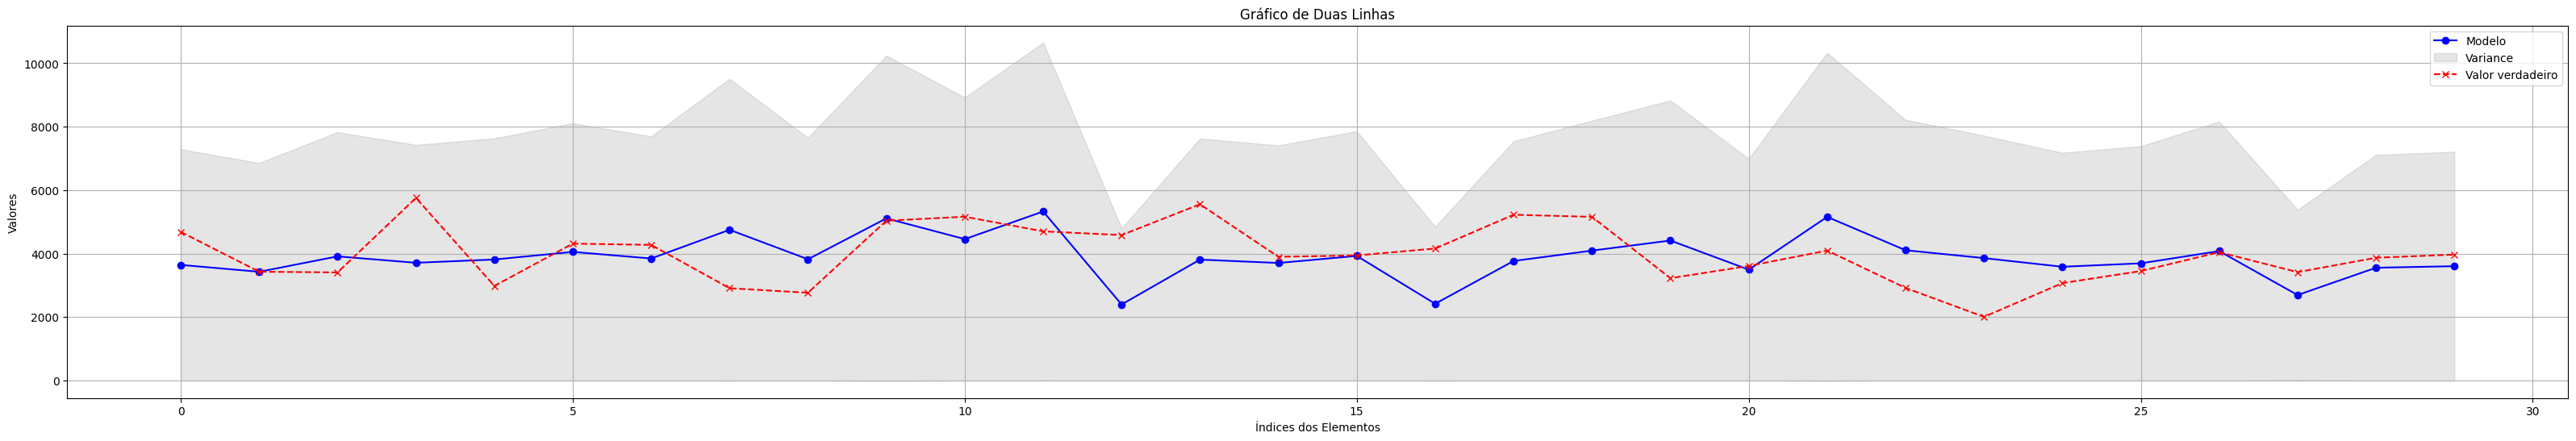

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 6))

# Perform element-wise addition and subtraction
upper_bound = np.stack([mean + var for mean, var in zip(mean_preds[:30], var_preds[:30])]).ravel()
lower_bound = np.stack([mean - var for mean, var in zip(mean_preds[:30], var_preds[:30])]).ravel()

# Criar o gráfico de linhas
plt.plot(mean_preds[:30], label='Modelo', color='blue', linestyle='-', marker='o')
plt.fill_between(range(30), lower_bound, upper_bound, color='gray', alpha=0.2, label='Variance')
plt.plot(targets_test[:30], label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

In [ ]:
upper_bound

[array([8249.002], dtype=float32),
 array([7284.146], dtype=float32),
 array([7828.797], dtype=float32),
 array([7985.6587], dtype=float32),
 array([7766.9453], dtype=float32),
 array([7782.6367], dtype=float32),
 array([7791.4727], dtype=float32),
 array([9225.783], dtype=float32),
 array([8125.622], dtype=float32),
 array([7844.6562], dtype=float32),
 array([7576.391], dtype=float32),
 array([7834.3955], dtype=float32),
 array([6542.9365], dtype=float32),
 array([8541.391], dtype=float32),
 array([8216.984], dtype=float32),
 array([8936.168], dtype=float32),
 array([7985.1904], dtype=float32),
 array([6989.3047], dtype=float32),
 array([6679.391], dtype=float32),
 array([8910.654], dtype=float32),
 array([7756.218], dtype=float32),
 array([7760.024], dtype=float32),
 array([7441.9297], dtype=float32),
 array([8441.422], dtype=float32),
 array([7453.84], dtype=float32),
 array([7503.6978], dtype=float32),
 array([7605.5063], dtype=float32),
 array([7385.7656], dtype=float32),
 array([

### Análises dos dados

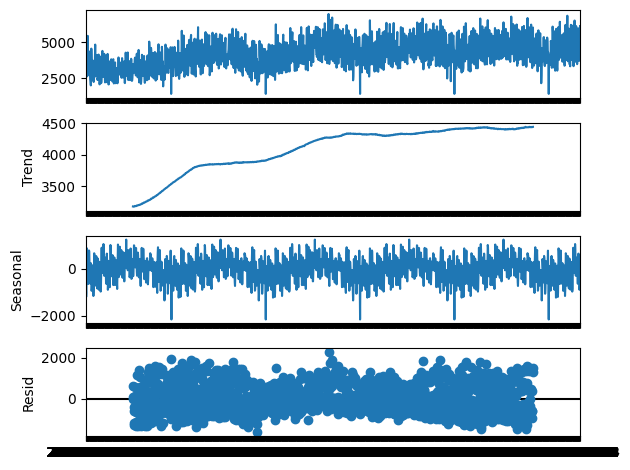

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_time_series, model='additive', period=365)
decomposition.plot()
plt.show()

In [ ]:
# Represenção do digrafo, aplicando cores e percentagens nas arrestas
dot = Digraph(comment='Grafo para descrever a Estrutura do Dados')

dot.node('A', f'Total de estados', color='lightblue2', style='filled')
dot.node('B', f'Estado CA', color='lightblue2', style='filled')
dot.node('C', f'Estado TX', color='lightblue2', style='filled')
dot.node('D', f'Estado W', color='lightblue2', style='filled')
dot.node('E', f'LOJA 1', color='lightblue2', style='filled')
dot.node('F', f'LOJA 2', color='lightblue2', style='filled')
dot.node('G', f'LOJA 3', color='lightblue2', style='filled')
dot.node('H', f'LOJA 4', color='lightblue2', style='filled')
dot.node('I', f'LOJA 1', color='lightblue2', style='filled')
dot.node('J', f'LOJA 2', color='lightblue2', style='filled')
dot.node('K', f'LOJA 3', color='lightblue2', style='filled')
dot.node('L', f'LOJA 1', color='lightblue2', style='filled')
dot.node('M', f'LOJA 2', color='lightblue2', style='filled')
dot.node('N', f'LOJA 3', color='lightblue2', style='filled')
dot.node('JA', f'CATEGORY HOBBIES', color='lightblue2', style='filled')
dot.node('JB', f'CATEGORY FOOD', color='lightblue2', style='filled')
dot.node('JC', f'CATEGORY HOUSEHOLD', color='lightblue2', style='filled')
dot.node('JAA', f'DEPARTAMENT HOBBIES 1', color='lightblue2', style='filled')
dot.node('JAB', f'DEPARTAMENT HOBBIES 2', color='lightblue2', style='filled')
dot.node('JBA', f'DEPARTAMENT FOOD 1', color='lightblue2', style='filled')
dot.node('JBB', f'DEPARTAMENT FOOD 2', color='lightblue2', style='filled')
dot.node('JBC', f'DEPARTAMENT FOOD 3', color='lightblue2', style='filled')
dot.node('JCA', f'DEPARTAMENT HOUSEHOLD 1', color='lightblue2', style='filled')
dot.node('JCB', f'DEPARTAMENT HOUSEHOLD 2', color='lightblue2', style='filled')


dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('A', 'D')
dot.edge('B', 'E')
dot.edge('B', 'F')
dot.edge('B', 'G')
dot.edge('B', 'H')
dot.edge('C', 'I')
dot.edge('C', 'J')
dot.edge('C', 'K')
dot.edge('D', 'L')
dot.edge('D', 'M')
dot.edge('D', 'N')
dot.edge('J', 'JA')
dot.edge('J', 'JB')
dot.edge('J', 'JC')
dot.edge('JA', 'JAA')
dot.edge('JA', 'JAB')
dot.edge('JB', 'JBA')
dot.edge('JB', 'JBB')
dot.edge('JB', 'JBC')
dot.edge('JC', 'JCA')
dot.edge('JC', 'JCB')

dot.render('/content/drive/MyDrive/Save/patient_dot', format='png', cleanup=True)

'/content/drive/MyDrive/Save/patient_dot.png'

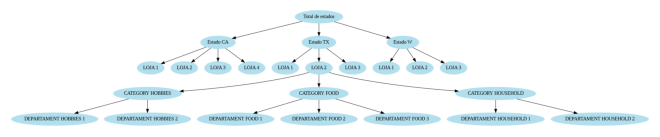

In [ ]:
image = mpimg.imread('/content/drive/MyDrive/Save/patient_dot.png')

fig, ax = plt.subplots() #criar uma subparcela única
ax.imshow(image) #exibir a imagem na subparcela e desativar os eixos
ax.axis('off')
#centralizar a imagem na subparcela
ax.set_position([0, 0, 1, 1])  # Define a posição da subparcela para cobrir toda a figura
#fig.savefig("/content/drive/MyDrive/Save/patient_dot.png")
plt.show() #pode nem ser colocado